In [1]:
import json
import time
import os

from pymongo import MongoClient

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from imputationtation import *

client = MongoClient("localhost", 27017)
db = client['usgs']

%matplotlib inline

In [ ]:
to_shift = {
    14137000 : -687,
    7377500  : +2,
    8186500  : +2,
    11456000 : +2
}

def get_data(db, site_id):
    data_m = db['measured'].find_one({'site_no': site_id})
    data_c = db['corrected'].find_one({'site_no': site_id})
    
    if data_m is None or data_c is None:
        raise Exception("Site not found")
        
    Tm = np.array(data_m['utc'], dtype=np.int32)
    Zm = np.array(data_m['gh'],  dtype=np.float32)
    
    Tc = np.array(data_c['utc'], dtype=np.int32)
    Zc = np.array(data_c['gh'],  dtype=np.float32)
    
    if site_id in to_shift:
        Zm += to_shift[site_id]
        Zc += to_shift[site_id]
    
    return Tm, Zm, Tc, Zc


def mark_anomaly(y_m, y_c, anomaly_thresh):
    return np.logical_or(y_c < 0, np.abs(y_c - y_m) > anomaly_thresh)  

In [4]:
sites = db['cites']
measured = db['measured']
corrected = db['corrected']

cursor = sites.find()
sid = [c['site_no'] for c in cursor]

14137000


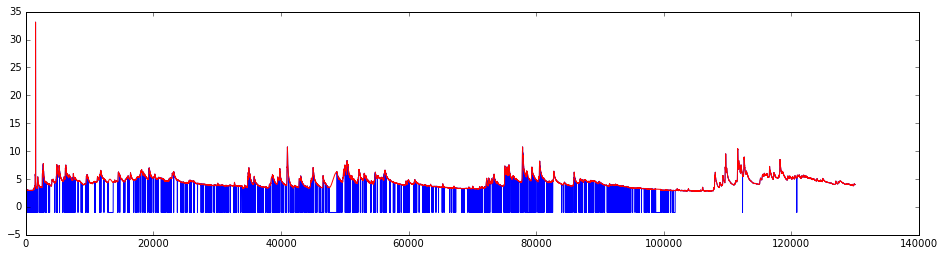

In [111]:
si = 14137000 # sorted(impurity)[-67]

Tm, Zm, Tc, Zc = get_data(db, si)

abs_thresh = np.median(Zm) + 15*np.subtract(*np.percentile(Zm, [90, 10]))
Zm[Zm <= 0] = -1
Zm[Zm > abs_thresh] = -1

Ym, Yc = align_measurements(Tm, Zm, Tc, Zc)  
Qm = fill_gaps(Ym, 10000, 10)

plt.figure(figsize = (16,4))
plt.plot(Ym, 'b-')
plt.plot(Qm, 'r-')
#plt.plot(Yc, 'r-')
#plt.ylim(4.2,5.0)
#plt.xlim(12800,13000)

print(si)